In [136]:
# dfca 4.3 needed
import subprocess as sp
import statistics, sys, os, shutil
import numpy as np
import deformetrica

In [137]:
import matplotlib.pyplot as plt
import matplotlib
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
%matplotlib inline

In [138]:
sys.path.append("/home/endrit/Documents/Scripts/SSM-V2/python/")
import ssm.pca, ssm.volumetric_meshes, ssm.atlas

# New Surfaces

List directories

In [139]:
ssm_dir = "/home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r2/"

In [181]:
odir = "/home/endrit/Documents/Modelling/Post_Repair_COA/SSM/sampled_modes/"

### Compute PCA

subjects, control_points, dim: (67, 172, 3)


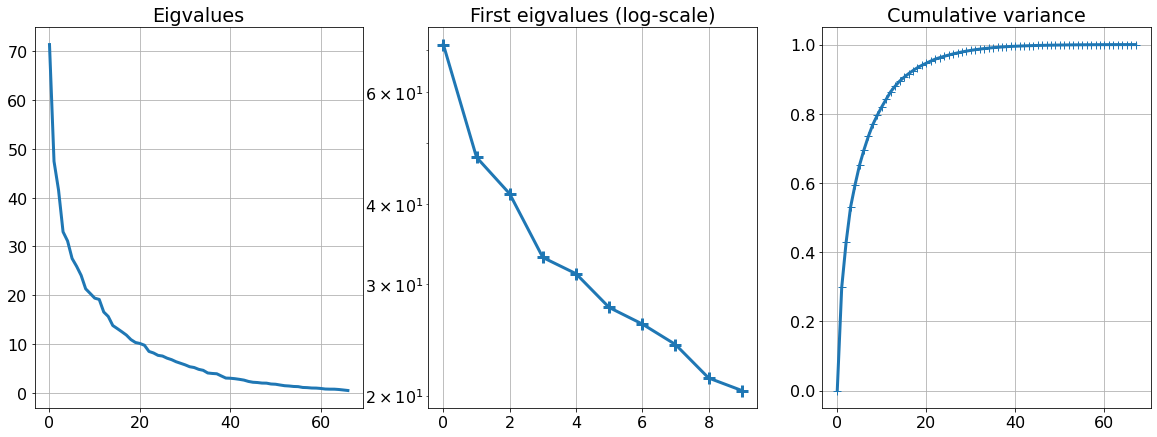

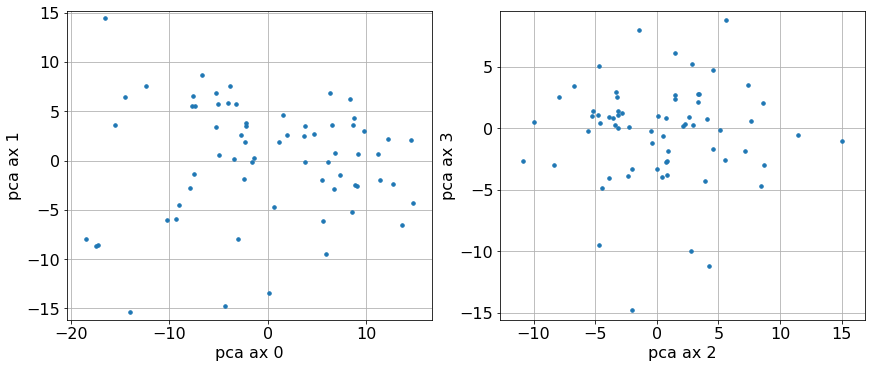

In [141]:
ao = ssm.pca.DeformetricaAtlasPCA(
    idir = ssm_dir + "output/",
    odir = ssm_dir + "pca/")

ao.compute_pca(with_plots=True)

In [142]:
# Reshape into U, S, Vt matrices
momenta = ao.momenta
nsbj = momenta.shape[0]
ndim = momenta.shape[1] * momenta.shape[2]
x = ao.momenta.reshape((nsbj, ndim))
pca_u = ao.pca_u
pca_s = ao.pca_s
pca_v = ao.pca_v

In [143]:
# print cumsum of PCA
cumsum_pca = np.concatenate((np.zeros(1), (pca_s**2).cumsum()/(pca_s**2).sum()))
print(cumsum_pca)

[0.         0.29804706 0.42981653 0.5309597  0.59474225 0.65145628
 0.69586823 0.73525945 0.76922193 0.795869   0.82021012 0.84230227
 0.86379423 0.87989818 0.89426618 0.90544374 0.9156279  0.92483844
 0.93308432 0.94009554 0.94636401 0.95238273 0.95798354 0.96222567
 0.96616433 0.96964403 0.97299693 0.97597609 0.97870566 0.98110439
 0.98327225 0.98521907 0.98691457 0.98850803 0.98988298 0.99114486
 0.99212995 0.99306707 0.99397519 0.99468925 0.99523736 0.99577217
 0.99627472 0.99673299 0.9971419  0.99747114 0.99775472 0.9980238
 0.99826588 0.99850366 0.99870245 0.99889089 0.99904811 0.99917878
 0.99929933 0.99940405 0.99950367 0.99957937 0.99965014 0.99971128
 0.99977059 0.99982125 0.99985999 0.99989631 0.99993217 0.9999624
 0.99998468 1.        ]


In [144]:
print(cumsum_pca[:35])

[0.         0.29804706 0.42981653 0.5309597  0.59474225 0.65145628
 0.69586823 0.73525945 0.76922193 0.795869   0.82021012 0.84230227
 0.86379423 0.87989818 0.89426618 0.90544374 0.9156279  0.92483844
 0.93308432 0.94009554 0.94636401 0.95238273 0.95798354 0.96222567
 0.96616433 0.96964403 0.97299693 0.97597609 0.97870566 0.98110439
 0.98327225 0.98521907 0.98691457 0.98850803 0.98988298]


In [80]:
# save pca matrices of training set
np.savetxt(odir + "pca_u.csv", pca_u, delimiter=',') # 66x66
np.savetxt(odir + "pca_s.csv", pca_s, delimiter=",") # 1x66
np.savetxt(odir + "pca_v.csv", pca_v, delimiter=",") # 480x480 (160 ctrl points * 3)

Compute StDev

In [145]:
n_subjects = 67

In [146]:
# select for maximal variance
n_modes = 35

In [147]:
def get_mean_stdev(n_subjects, n_modes, pca_matrix):
        """
        build matrix of mean and stdev per mode:
        output: rows=modes, col_0 = mean score per mode, col_1 = stdev of scores per mode
        
        Modes that are excluded given 0 mean and 0 stdev.
        """
        matrix = np.zeros(shape=(n_subjects, 2))

        for i in range(n_subjects):
            if i < n_modes:
                matrix[i][0] = statistics.mean(pca_matrix[:,i])
                matrix[i][1] = statistics.stdev(pca_matrix[:,i])
            else:
                matrix[i][0] = 0
                matrix[i][1] = 0
        return matrix

In [148]:
mean_stdev = get_mean_stdev(n_subjects, n_modes, pca_u)

Sample Gaussian

In [171]:
def sample_gaussian(new_subjects, n_subjects, stats_arr):
        """
        make new pca u [subjects, modes]
        sample within 2 stdev (limit extreme deformations)
        """
        new_shapes = np.zeros(shape=(new_subjects, n_subjects))
        for i in range(new_subjects):
            for j in range(n_subjects):
                mu = stats_arr[j][0]
                sigma = stats_arr[j][1]
                x = np.random.normal(mu, sigma)
                if x < mu - 2*sigma:
                    x = mu - 2*sigma
                if x > mu + 2*sigma:
                    x = mu + 2*sigma
                new_shapes[i][j] = x
        return new_shapes

In [172]:
# number of subjects to generate
n_new_subjects = 30

pca_u_new = sample_gaussian(n_new_subjects, n_subjects, mean_stdev)

In [173]:
# write concat pca_u file (for ML)
np.savetxt(odir + "pca_u_new_shapes_concat.csv", pca_u_new, delimiter=",")

Create Momenta txt file

In [174]:
def generate_momenta(new_subjects, batch_size, pca_new, ofile):
        """
        reverse svd to get momenta u@s@v = momenta
        only 66 subjects at a time, or matrix mul doesnt work        
        """
        s = np.dot(np.diag(pca_s), pca_v[0:batch_size, :])
        
        with open(ofile, 'w') as outfile:
            # start writing momenta file
            outfile.write(str(new_subjects)+' '+str(momenta.shape[1])+' '+str(momenta.shape[2])+'\n')
            outfile.write('\n')
            for i in range(0, new_subjects, batch_size):
                """
                calculate momenta for each batch
                """
                b = max(new_subjects, i + batch_size)
                usv = np.dot(pca_new[i:b, :], s)
                M = usv.reshape((-1, momenta.shape[1], 3))
                # write each subject from batch into momenta file
                for subject in M:
                    np.savetxt(outfile, subject, fmt='%-3.20f')
                    outfile.write('\n')

In [175]:
# total new subjects to be written to momenta
#n_total_new = (batches+1)*n_subjects

#generate_momenta(n_total_new, n_subjects, pca_u_new, odir + "pca_u_new_shapes_momenta.txt")
generate_momenta(n_new_subjects, n_subjects, pca_u_new, odir + "pca_u_new_shapes_momenta.txt")

Shooting

In [213]:
def shoot(idir, odir, kw, noise):

        ftemplate = idir + "output/DeterministicAtlas__EstimatedParameters__Template_Aorta.vtk"
        fctrlpts = idir + "output/DeterministicAtlas__EstimatedParameters__ControlPoints.txt"
        # new momenta file
        fmoments = odir + "pca_u_new_shapes_momenta.txt"

        sp.call(["mkdir", "-p", odir+"new_shapes/"])

        # warping polydata
        template_specifications = {
            'new_shape': {'deformable_object_type': 'surfacemesh', 
                        'noise_std': noise,
                        'kernel_type':'torch', 'kernel_width':kw,
                        'filename': ftemplate}}
        
        model_options={
                    'dimension': 3,
                    'deformation_kernel_type': 'torch',
                    'deformation_kernel_width': kw,
                    'tmin':0,
                    'tmax':1,
                    "initial_control_points": fctrlpts,
                    "initial_momenta": fmoments}
    
        Deformetrica = deformetrica.api.Deformetrica(verbosity="INFO", output_dir=odir+"new_shapes/")
        Deformetrica.compute_shooting(template_specifications, model_options=model_options)

In [178]:
kw = 20.
noise = 5.

shoot(ssm_dir, odir, kw, noise)

Logger has been set to: INFO
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 12
context has already been set
[ compute_shooting function ]
Defaulting geodesic t0 to 1.


/home/endrit/anaconda3/envs/dfca-env-4.3/lib/python3.8/site-packages/deformetrica/in_out/dataset_functions.py:279: UserWarning: Watch out, I did not get a distance type for the object new_shape, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)


**Clear folder of shooting files**

In [179]:
# rename final surface files
for ifile in sorted(os.listdir(odir+"new_shapes/")):
        if ifile.__contains__("__GeodesicFlow__"):
            new_name = ifile.replace("__GeodesicFlow__new_shape__tp_10__age_1.00.vtk", ".vtk")
            os.rename(odir+"new_shapes/"+ifile, odir+"new_shapes/"+new_name)

In [180]:
# delete files
for ifile in sorted(os.listdir(odir+"new_shapes/")):
        if ifile.__contains__("__GeodesicFlow__"):
            os.remove(odir+"new_shapes/"+ifile)

# New Volumes

In [129]:
vol_dir = "/home/endrit/Documents/Modelling/Post_Repair_COA/SSM/new_volumes_2/"

# make sure template and directories are correct
ae = ssm.atlas.DeformetricaAtlasEstimation(
    idir=ssm_dir,
    odir=vol_dir,
    initial_guess=ssm_dir + '/output/DeterministicAtlas__EstimatedParameters__Template_Aorta.vtk',
    kwd=20.,
    kwg=15.,
    noise=5.)

In [131]:
# new template
template_vtu = ssm_dir + "DeterministicAtlas__EstimatedParameters__Template_Aorta.vtu"

In [132]:
# new momenta file
fmmt = odir + "pca_u_new_shapes_momenta.txt"

In [133]:
# ctrl points
fctp = ssm_dir + "output/DeterministicAtlas__EstimatedParameters__ControlPoints.txt"

In [134]:
ssm.volumetric_meshes.shoot_vtu(fin=template_vtu, 
                                fvtk=ae.odir+"vtu/points.vtk", 
                                fmoments=fmmt, 
                                fctrlpts=fctp, 
                                odir=ae.odir+"vtu/",
                                fout=ae.odir+"vtu/vol_mesh.vtu", 
                                kw=ae.p_kernel_width_deformation, 
                                noise=ae.p_noise, 
                                name=ae.id)

shooting N points: 29000 29000
Logger has been set to: INFO
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 12
context has already been set
[ compute_shooting function ]
Defaulting geodesic t0 to 1.


In [135]:
# delete shooting files
for ifile in sorted(os.listdir(vol_dir + "vtu/")):
        if ifile.__contains__("Shooting"):
            os.remove(vol_dir + "/vtu/" + ifile)

# Sample Mode 0 vs Mode 1 Grid

Assume mean ~0 and stdev ~0.25 for all modes  
Each step = 0.025  
Use integers then /10000 to avoid floating point errors.

In [182]:
x_mean, x_range = 0, 250
pca_mode_range = np.arange(-x_range, x_range+25, 25)
pca_mode_range = pca_mode_range/1000

In [183]:
# becomes x axis (mode 0)
mode_range_stretched = np.repeat(pca_mode_range, 21, axis=0)

In [184]:
# becomes y axis (mode 1)
mode_range_cloned = np.tile(pca_mode_range, 21)

Construct new pca u grid of values (-0.25 to 0.25 for X and Y)

In [191]:
pca_u_grid = np.zeros((441, n_subjects), dtype=float)
for i in range(np.shape(pca_u_grid)[0]):
    pca_u_grid[i, 0] = mode_range_stretched[i]
    pca_u_grid[i, 1] = mode_range_cloned[i]

In [192]:
# save pca u matrix csv
np.savetxt(odir + "pca_u_grid_concat.csv", pca_u_grid, delimiter=",")

In [193]:
generate_momenta(441, n_subjects, pca_u_grid, odir + "pca_u_grid_concat.txt")

In [197]:
shoot(ssm_dir, odir, kw, noise)

Logger has been set to: INFO
OMP_NUM_THREADS found in environment variables. Using value OMP_NUM_THREADS=12
context has already been set
[ compute_shooting function ]


/home/endrit/anaconda3/envs/dfca-env-4.3/lib/python3.8/site-packages/deformetrica/in_out/dataset_functions.py:279: UserWarning: Watch out, I did not get a distance type for the object new_shape, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)


Defaulting geodesic t0 to 1.


In [198]:
# rename final surface files
for ifile in sorted(os.listdir(odir+"new_shapes/")):
        if ifile.__contains__("__GeodesicFlow__"):
            new_name = ifile.replace("__GeodesicFlow__new_shape__tp_10__age_1.00.vtk", ".vtk")
            os.rename(odir+"new_shapes/"+ifile, odir+"new_shapes/"+new_name)

In [199]:
# delete files
for ifile in sorted(os.listdir(odir+"new_shapes/")):
        if ifile.__contains__("__GeodesicFlow__"):
            os.remove(odir+"new_shapes/"+ifile)

# Sample Individual Modes

In [299]:
mode_dir = odir + "mode_9/"
sp.call(["mkdir", "-p", mode_dir])

0

In [300]:
x_mean, x_range = 0, 250
pca_mode_range = np.arange(-x_range, x_range+25, 25)
pca_mode_range = pca_mode_range/1000

In [301]:
pca_u_mode = np.zeros((21, n_subjects), dtype=float)

# change col to sample a specific mode
for i in range(np.shape(pca_u_mode)[0]):
    pca_u_mode[i, 9] = pca_mode_range[i]

In [302]:
generate_momenta(21, n_subjects, pca_u_mode, mode_dir + "/pca_u_new_shapes_momenta.txt")

In [303]:
shoot(ssm_dir, mode_dir, kw, noise)

Logger has been set to: INFO
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 12
context has already been set
[ compute_shooting function ]
Defaulting geodesic t0 to 1.


/home/endrit/anaconda3/envs/dfca-env-4.3/lib/python3.8/site-packages/deformetrica/in_out/dataset_functions.py:279: UserWarning: Watch out, I did not get a distance type for the object new_shape, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)


In [304]:
# rename final surface files
for ifile in sorted(os.listdir(mode_dir+"new_shapes/")):
        if ifile.__contains__("__GeodesicFlow__"):
            new_name = ifile.replace("__GeodesicFlow__new_shape__tp_10__age_1.00.vtk", ".vtk")
            os.rename(mode_dir+"new_shapes/"+ifile, mode_dir+"new_shapes/"+new_name)

In [305]:
# delete files
for ifile in sorted(os.listdir(mode_dir+"new_shapes/")):
        if ifile.__contains__("__GeodesicFlow__"):
            os.remove(mode_dir+"new_shapes/"+ifile)